In [ ]:
! pip install deepchem
! pip install propy3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.2/693.2 KB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.3/29.3 MB 28.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.3/290.3 KB 5.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#read the data
import pandas as pd
data = pd.read_csv("/content/drive/Shareddrives/2:1 Caitlin & Kimai/Data/Enzyme Stability Prediction/train.csv")
data.head()

,seq_id,protein_sequence,pH,data_source,tm
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5


In [ ]:
data.shape

(31390, 5)

In [ ]:
#getting the length of the protein sequences
data['length'] = data['protein_sequence'].str.len()

print("Maximum length is: {}".format(data['length'].max()))
print("Minimum length is: {}".format(data['length'].min()))

Maximum length is: 32767
Minimum length is: 5


In [ ]:
data.head()

,seq_id,protein_sequence,pH,data_source,tm,length
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7,341
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5,286
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5,497
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2,265
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5,1451


## Pre-processing

- In the following cell, we are creating and pyPro Object based on the protein sequence. Pypro allows us the calculation of amino acid composition vectors
Here we create a list with the aminoacido composition vector for each sequence.

In [ ]:
from propy import PyPro

In [ ]:
import numpy as np 
aacd = [] #Amino Acid Composition Descriptors(20)
ctdd = [] #Composition Transition Distribution descriptors
for seq in data['protein_sequence'].to_list():
    Obj = PyPro.GetProDes(seq)
    aacd.append(np.array(list(Obj.GetAAComp().values())))
    ctdd.append(np.array(list(Obj.GetCTD().values())))

label = data['tm'].values

In [ ]:
print(len(aacd[0]))

20


In [ ]:
#creating the dataframes
import deepchem as dc
dataset_aacd = dc.data.NumpyDataset(X = aacd, y = label)
dataset_ctdd = dc.data.NumpyDataset(X = ctdd, y = label)

In [ ]:
dataset_aacd

<NumpyDataset X.shape: (31390, 20), y.shape: (31390,), w.shape: (31390,), task_names: [0]>

## Model Building
### Using deepchem

In [ ]:
#splitting the dataset
from deepchem import splits
splitter = splits.RandomSplitter()
train, test  = splitter.train_test_split(dataset_aacd,seed=42)

### RandomForest Regressor

In [ ]:
#building the model
from sklearn.ensemble import RandomForestRegressor
from deepchem.utils.evaluate import Evaluator

model = RandomForestRegressor()
model = dc.models.SklearnModel(model)
model.fit(train)

#assessing the model
#getting r2_score
metric = dc.metrics.Metric(dc.metrics.r2_score)
#mean squared error
metric1 = dc.metrics.Metric(dc.metrics.mean_squared_error)

train_score = model.evaluate(train, [metric])
test_score = model.evaluate(test, [metric])

train_score1 = model.evaluate(train, [metric1])
test_score1 = model.evaluate(test, [metric1])

#printing scores
print("Train score is : {}".format(train_score))
print("Test score is : {}".format(test_score))
print("Train Error is : {}".format(train_score1))
print("Test Error is : {}".format(test_score1))

Train score is : {'r2_score': 0.8555378462437185}
Test score is : {'r2_score': 0.5547702412899865}
Train Error is : {'mean_squared_error': 28.311400645606543}
Test Error is : {'mean_squared_error': 87.90202598136051}


In [ ]:
RMSE = np.sqrt(87.90202598136051)
print(RMSE)

9.375608032621699


## Model Building
### Without deepchem

In [ ]:
#creating a dataframe
array1 = np.array(aacd)
df = pd.DataFrame(array1, columns = ["column {}".format(i) for i in range(1,21)])
df['label'] = label
df.head()

,column 1,column 2,column 3,column 4,column 5,column 6,column 7,column 8,column 9,column 10,...,column 12,column 13,column 14,column 15,column 16,column 17,column 18,column 19,column 20,label
0,13.196,7.331,1.466,3.812,0.293,8.798,1.760,11.144,0.880,4.106,...,4.692,2.346,3.812,5.279,3.226,4.106,1.173,0.880,10.850,75.7
1,9.790,10.490,2.098,3.497,0.000,18.182,7.692,6.294,1.399,4.545,...,6.643,0.699,2.098,2.797,4.895,4.196,1.049,1.049,4.545,50.5
2,10.060,6.237,3.018,5.433,1.811,6.439,5.030,13.078,2.213,3.219,...,7.847,1.207,4.225,4.024,6.640,6.036,0.604,3.219,6.036,40.5
3,7.547,3.774,3.396,7.170,1.887,10.943,3.396,6.038,2.642,3.774,...,6.415,0.755,4.528,6.038,6.038,7.170,1.132,1.509,5.283,47.2
4,5.927,4.342,4.480,5.376,0.965,5.376,3.722,5.789,2.757,4.893,...,4.686,2.136,2.205,8.822,10.200,8.270,1.103,3.239,8.546,49.5


In [ ]:
#train test split
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
x_train, x_test, y_train, y_test = train_test_split(array1, label, test_size = 0.2, random_state = 0)

### RandomForest Regressor
- Best n_estimators when max_depth is default - 73

In [ ]:
from sklearn.ensemble import RandomForestRegressor
#building the model
model = RandomForestRegressor(n_estimators = 100, max_depth = 7) # 50 - 9.11, 40 - 9.14, 30 - 9.15, 20 - 9.25, 10 - 9.44
#50 is the best
model.fit(x_train,y_train)

#predictions
y_pred = model.predict(x_test)

#evaluation
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: {}".format(RMSE))
print("Training Model Score: {}".format(r2_score(y_train, model.predict(x_train))))
print("Testing Model Score: {}".format(r2_score(y_test,y_pred)))

RMSE: 10.45432958672921
Training Model Score: 0.4873313268617544
Testing Model Score: 0.4111126742658219


In [ ]:
%%time
max_depth = [1,2,3,4,5,6,7]
n_trees = [i for i in range(10,110,10)]

all_acc = []

for depth in max_depth:
  acc = []
  for tree in n_trees:
    print(depth, tree)
    model1 = RandomForestRegressor(n_estimators=tree, max_depth=depth)
    model1.fit(x_train,y_train)
    y_pred = model1.predict(x_test)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    acc.append(RMSE)
  all_acc.append(acc)


1 10
1 20
1 30
1 40
1 50
1 60
1 70
1 80
1 90
1 100
2 10
2 20
2 30
2 40
2 50
2 60
2 70
2 80
2 90
2 100
3 10
3 20
3 30
3 40
3 50
3 60
3 70
3 80
3 90
3 100
4 10
4 20
4 30
4 40
4 50
4 60
4 70
4 80
4 90
4 100
5 10
5 20
5 30
5 40
5 50
5 60
5 70
5 80
5 90
5 100
6 10
6 20
6 30
6 40
6 50
6 60
6 70
6 80
6 90
6 100
7 10
7 20
7 30
7 40
7 50
7 60
7 70
7 80
7 90
7 100
CPU times: user 8min 44s, sys: 620 ms, total: 8min 45s
Wall time: 8min 49s


Text(0.5, 1.0, 'MAE values respective to max_depth and number of trees')

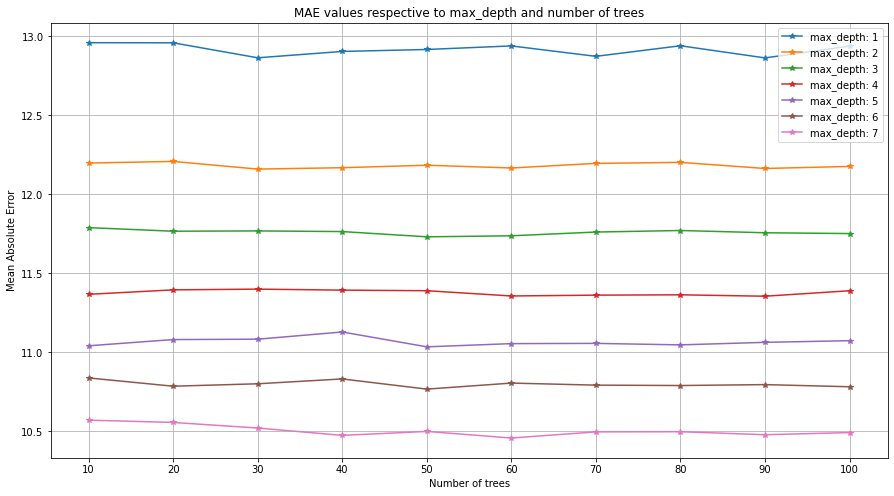

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (15,8))
for index in range(len(max_depth)):
  plt.plot(n_trees,all_acc[index],"*-", label = f"max_depth: {index + 1}")
plt.xlabel("Number of trees")
plt.ylabel("Mean Absolute Error")
plt.legend(loc = "best")
plt.xticks([i for i in range(10,110,10)])
plt.grid(True)
plt.title("MAE values respective to max_depth and number of trees")

# Homework

- Try it for range(1, 50) and run this and find the best number of estimators.

In [ ]:
from sklearn.model_selection import GridSearchCV
#hyper paramter tuning
model = RandomForestRegressor()
params = {"n_estimators":[i for i in range(1,3)]}
gscv = GridSearchCV(model, params, cv = 5, n_jobs = -1)
gscv.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'n_estimators': [1, 2]})

In [ ]:
gscv.best_estimator_

RandomForestRegressor(n_estimators=2)

### Linear Regression

In [ ]:
#building the model
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train,y_train)

#preditions
y_pred = model.predict(x_test)

#evaluation
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: {}".format(RMSE))
print("Training Model Score: {}".format(r2_score(y_train, model.predict(x_train))))
print("Testing Model Score: {}".format(r2_score(y_test,y_pred)))

RMSE: 12.401521928818054
Training Model Score: 0.20174086130440216
Testing Model Score: 0.1713143792876557


In [ ]:
RMSE_values = {}

### KNNRegressor

In [ ]:
#building the model
from sklearn.neighbors import KNeighborsRegressor
neighbors = 5
model = KNeighborsRegressor(n_neighbors=neighbors)
model.fit(x_train,y_train)

#prediction
y_pred = model.predict(x_test)

#evaluation
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: {}".format(RMSE))
print("Training Model Score: {}".format(r2_score(y_train, model.predict(x_train))))
print("Testing Model Score: {}".format(r2_score(y_test,y_pred)))

RMSE: 9.501832686522954
Training Model Score: 0.6863852759887641
Testing Model Score: 0.5135316503429008


In [ ]:
neighbors = [i for i in range(1,21)]
RMSE = []

for k in neighbors:
  model1 = KNeighborsRegressor(n_neighbors=k)
  model1.fit(x_train,y_train)
  y_pred1 = model1.predict(x_test)
  RMSE.append(np.sqrt(mean_squared_error(y_test, y_pred1)))

import matplotlib.pyplot as plt

plt.figure(figsize = (8,8))
plt.plot(neighbors, RMSE, '*-')
plt.xlabel("Neighbors")
plt.ylabel("Root Mean Squared Value")
plt.xticks([i for i in range(1,21)])
plt.grid(True)
plt.show()


In [ ]:
neighbors = [i for i in range(1,21)]

In [ ]:
for number in range(1,21):
  print(number)